In [1]:
from sklearn.linear_model import LogisticRegression
from fastsklearnfeature.dfs.SimulatedAnnealing import SimulatedAnnealing
from fastsklearnfeature.dfs.TPEChi2 import TPEChi2
from fastsklearnfeature.dfs.SFS import SFS
from fastsklearnfeature.dfs.DataLoader import DataLoader
from fastsklearnfeature.dfs.QueryOptimizer import QueryOptimizer
from fastsklearnfeature.dfs.ForwardSelection import ForwardSelection
import numpy as np
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

# Notebook for Declarative Feature Selection (DFS)

We describe how to interactively design ML scenarios that DFS can solve for you.

The first step is loading the data. You need to define a training, a validation and a test set. Here, we use the Adult dataset where we have to classify whether the yearly income of a person exceeds $50K.

In [2]:
dl = DataLoader()
X_train, X_validation, X_test, y_train, y_validation, y_test, feature_names, sensitive_ids = dl.get_data(dataset='Adult')

Now, you can use potentially any feature selection strategy to satisfy your ML application constraints. Here, our application constraint is that we need a minimum accuracy of 80% and we choose to apply the well-known sequential forward selection strategy for search.

In [3]:
sfs = ForwardSelection(floating=False)
sfs.query(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			max_search_time=120,
			feature_names=feature_names
			)

FS: 0.0818875852260987
FS: 0.08228883116064888
FS: 0.0898386084786239
FS: 0.06451659561193222
FS: 0.07152857579712155
FS: 0.08581423836936988
FS: 0.08920513484188367
FS: 0.0897982832290123
FS: 0.07766583843976167
FS: 0.08126111220689893
FS: 0.07887624980633778
FS: 0.08622350941269297
FS: 0.08839980910485115
FS: 0.0870083700663291
FS: 0.0846926700345205
FS: 0.0859432451941437
FS: 0.08933549464372019
FS: 0.08755862250289816
FS: 0.046984284388511675
function took longer than 120 seconds


array([], dtype=float64)

As you see, this feature selection strategy does not find a solution for the specified constraint within in the specified maximum search time. Here, you can see the progress over time:

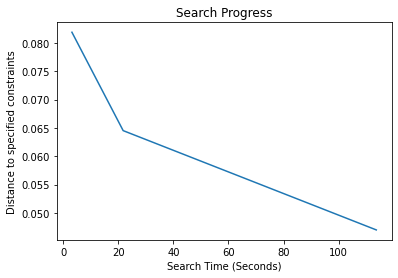

In [4]:
sfs.get_progress()

So, instead of manually choosing the feature selection strategy, we trained a meta-learning-driven query optimizer based on 1200 different ML scenarios across 20 datasets.
This optimizer will automatically choose the feature selection strategy that it estimates to have the highest chance of success:

In [5]:
optimizer = QueryOptimizer()
optimizer.query(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			max_search_time=120,
			feature_names=feature_names
			)

Within 10.51041293144226 seconds, the Optimizer chose to run TPE(FCBF)
100%|██████████| 1/1 [00:04<00:00,  4.13s/trial, best loss: 0.0]


array(['workclass_Self-emp-inc', 'workclass_missing', 'education_10th',
       'education_11th', 'education_Bachelors', 'education_Doctorate',
       'education_HS-grad', 'education_Masters', 'education_Prof-school',
       'marital-status_Divorced', 'marital-status_Married-civ-spouse',
       'marital-status_Never-married', 'marital-status_Separated',
       'occupation_Adm-clerical', 'occupation_Exec-managerial',
       'occupation_Handlers-cleaners', 'occupation_Other-service',
       'occupation_Prof-specialty', 'occupation_missing',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife', 'race_Black',
       'sex_Female', 'sex_Male', 'age', 'fnlwgt', 'education-num',
       'capital-gain', 'capital-loss', 'hours-per-week'], dtype='<U41')

As we see, the optimizer chooses the feature selection strategy TPE(FCBF) that quickly yields a set of features that satisfy all specified constraints. The optimizer estimates for each strategy the likelihood of success for the specified ML scenario, as shown in the next cell:

Within 9.967130661010742 seconds, the Optimizer chose to run TPE(FCBF)


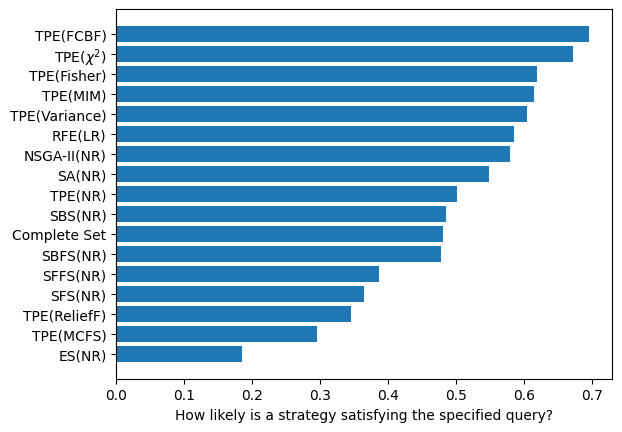

In [6]:
optimizer.get_plan(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			max_search_time=120,
			feature_names=feature_names
			)

Here, we see that indeed the sequential forward selection strategy (SFS) was a poor choice for this ML scenario. If you are more interested why the optimizer chose TPE(FCBF), we can use the explainability library ELI5 to explain the prediction: 

In [7]:
optimizer.explain_plan_choice()

Here, we see that the optimizer favored TPE(FCBF) because of the accuracy distance to the landmark result and the number of rows.

However, we are not only interested in accuracy, we are also looking for a fair feature representation. Therefore, we set the minimum fairness to 85%. Furthermore, we have specify the binary features that contain the sensitive attribute that should be fair (sensitive_ids). In our case, the sensitive attribute is gender.

In [8]:
optimizer.query(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			sensitive_ids=sensitive_ids,
			min_fairness=0.85,
			max_search_time=120,
			feature_names=feature_names
			)

Within 10.400004386901855 seconds, the Optimizer chose to run TPE($\chi^2$)
100%|██████████| 13/13 [00:03<00:00,  3.88trial/s, best loss: 0.001244703879186755]
function took longer than 120 seconds


array([], dtype=float64)

Unfortunately, the strategy that the optimizer proposed did not yield a solution. Therefore, we can ask the optimizer how to adjust our constraints in order to improve the likelihood of success:

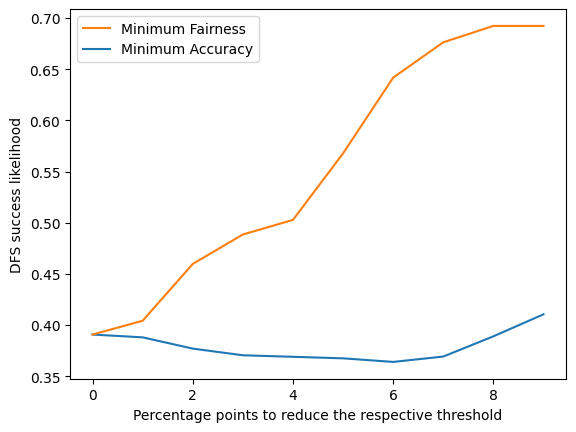

In [9]:
optimizer.how_to_improve_the_success_likelihood()

Here, we see how much the likelihood of success increases if we either decrease the fairness or accuracy constraint by 1, 2, ... 8 percentage points. We see that reducing fairness inceases the likelihood signficantly. Therefore, we reduce fairness by 5% to 80% and rerun:

In [10]:
optimizer.query(X_train,
			X_validation,
			X_test,
			y_train,
			y_validation,
			y_test,
			min_accuracy=0.80,
			sensitive_ids=sensitive_ids,
			min_fairness=0.80,
			max_search_time=120,
			feature_names=feature_names
			)

Within 10.149172306060791 seconds, the Optimizer chose to run TPE(FCBF)
100%|██████████| 1/1 [00:06<00:00,  6.38s/trial, best loss: 0.0]


array(['workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_missing', 'education_10th',
       'education_11th', 'education_12th', 'education_1st-4th',
       'education_5th-6th', 'education_7th-8th', 'education_9th',
       'education_Assoc-acdm', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent',
       'marital-status_Never-married', 'marital-status_Separated',
       'marital-status_Widowed', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',

Finally, we can show the resulting scores across metrics for the test data:

In [11]:
fig = optimizer.get_test_radar_chart()
iplot(fig) 

As you can see the represetation satisfies all specified constraints of accuracy and fairness, but has a high number of features (high complixity = low simplicity) and a low safety against adversarial examples. Now, it's your turn to play around a bit more with declarative feature selection.